In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Section 1) Fetch of the Kaggle Cats vs Dogs dataset (5%)

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  4  786M    4 37.8M    0     0  37.8M      0  0:00:20  0:00:01  0:00:19 30.6M
 11  786M   11 88.2M    0     0  44.1M      0  0:00:17  0:00:02  0:00:15 39.4M
 18  786M   18  146M    0     0  48.8M      0  0:00:16  0:00:03  0:00:13 45.3M
 25  786M   25  200M    0     0  50.1M      0  0:00:15  0:00:04  0:00:11 47.3M
 33  786M   33  260M    0     0  52.0M      0  0:00:15  0:00:05  0:00:10 51.8M
 41  786M   41  329M    0     0  54.8M      0  0:00:14  0:00:06  0:00:08 58.2M
 50  786M   50  394M    0     0  56.3M      0  0:00:13  0:00:07  0:00:06 60.8M
 57  786M   57  452M    0     0  56.5M      0  0:00:13  0:00:08  0:00:05 61.1M
 63  786M   63  502M    0     0  55.8M      0  0:00

In [ ]:
!unzip -q kagglecatsanddogs_3367a.zip

In [2]:
!dir PetImages

 Volume in drive C is Acer
 Volume Serial Number is 6CEB-6195

 Directory of C:\Users\alan8\source\visual 2\applied-ML\Week 4\PetImages

09/20/2021  09:20 PM    <DIR>          .
09/20/2021  09:20 PM    <DIR>          ..
09/20/2021  09:20 PM    <DIR>          Cat
09/20/2021  09:23 PM    <DIR>          Dog
               0 File(s)              0 bytes
               4 Dir(s)  54,242,947,072 bytes free


# Section 2) Coding of the convolutional neural network from scratch following the code example from keras.io (https://keras.io/examples/vision/image_classification_from_scratch/) (30%)

In [3]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1578 images


In [4]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

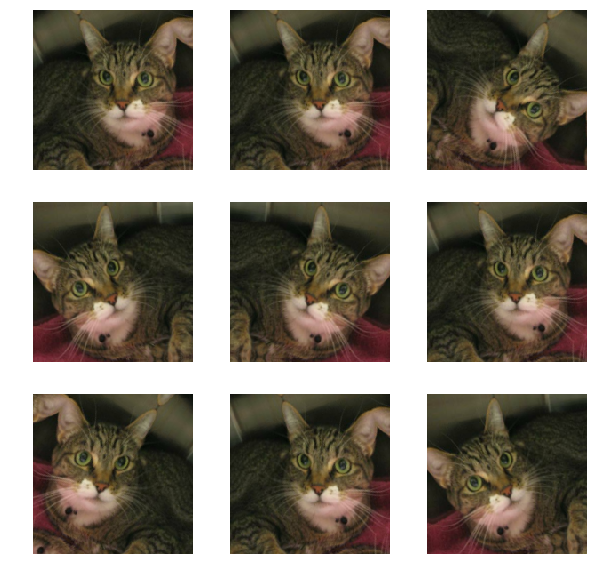

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Section 3) Calculation of the accuracy of the model with 25 epochs and then 50 epochs (15%)

In [16]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/25
586/586 [==============================] - 1433s 2s/step - loss: 0.6527 - accuracy: 0.6368 - val_loss: 0.8365 - val_accuracy: 0.5816


D:\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
586/586 [==============================] - 1515s 3s/step - loss: 0.5032 - accuracy: 0.7613 - val_loss: 0.4199 - val_accuracy: 0.8044
Epoch 3/25
586/586 [==============================] - 1745s 3s/step - loss: 0.3959 - accuracy: 0.8232 - val_loss: 0.3557 - val_accuracy: 0.8523
Epoch 4/25
586/586 [==============================] - 1529s 3s/step - loss: 0.3343 - accuracy: 0.8553 - val_loss: 0.3053 - val_accuracy: 0.8683
Epoch 5/25
586/586 [==============================] - 1534s 3s/step - loss: 0.2806 - accuracy: 0.8830 - val_loss: 0.2708 - val_accuracy: 0.8909
Epoch 6/25
586/586 [==============================] - 2144s 4s/step - loss: 0.2468 - accuracy: 0.8950 - val_loss: 0.4589 - val_accuracy: 0.8202
Epoch 7/25
586/586 [==============================] - 1598s 3s/step - loss: 0.2242 - accuracy: 0.9077 - val_loss: 0.1713 - val_accuracy: 0.9321
Epoch 8/25
586/586 [==============================] - 1557s 3s/step - loss: 0.1943 - accuracy: 0.9202 - val_loss: 0.1882 - val_accuracy:

In [11]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 1425s 2s/step - loss: 0.6050 - accuracy: 0.6766 - val_loss: 0.5103 - val_accuracy: 0.7549


D:\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
586/586 [==============================] - 1330s 2s/step - loss: 0.4485 - accuracy: 0.7928 - val_loss: 0.4014 - val_accuracy: 0.8160
Epoch 3/50
586/586 [==============================] - 1320s 2s/step - loss: 0.3566 - accuracy: 0.8437 - val_loss: 0.9001 - val_accuracy: 0.6676
Epoch 4/50
586/586 [==============================] - 1316s 2s/step - loss: 0.2916 - accuracy: 0.8754 - val_loss: 0.2360 - val_accuracy: 0.8999
Epoch 5/50
586/586 [==============================] - 1318s 2s/step - loss: 0.2545 - accuracy: 0.8956 - val_loss: 0.2420 - val_accuracy: 0.9058
Epoch 6/50
586/586 [==============================] - 1320s 2s/step - loss: 0.2280 - accuracy: 0.9050 - val_loss: 0.2685 - val_accuracy: 0.8860
Epoch 7/50
586/586 [==============================] - 1318s 2s/step - loss: 0.2055 - accuracy: 0.9137 - val_loss: 0.2411 - val_accuracy: 0.8973
Epoch 8/50
586/586 [==============================] - 1320s 2s/step - loss: 0.1845 - accuracy: 0.9242 - val_loss: 0.5785 - val_accuracy:

# Section 4) Code an option that prompts the user for an image online (user to write the full URL of an image) (20%)

In [17]:
# ask for user
userpic = input('please fill in the URL of the image')

please fill in the URL of the imagehttps://www.hj9l.com/uploadfile/2015/0703/20150703082618184.jpg


In [18]:
# download the image which user provided
import urllib.request

urllib.request.urlretrieve(userpic,"userpic.jpg")

('userpic.jpg', <http.client.HTTPMessage at 0x1ac826005f8>)

# Section 5) Run your predictor model in the image from the URL submitted by the user and provide the best classification of whether the image is a dog or a cat. (30%)

In [19]:
img = keras.preprocessing.image.load_img(
    "userpic.jpg", target_size=image_size      # put the image name
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent cat and 100.00 percent dog.


In [23]:
if score > 0.5:
    print ('The image is a dog')
else:
    print('The image is a cat')

The image is a dog
